In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import metpy.calc as mpcalc
import metpy
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap,LinearSegmentedColormap


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt

## Load in example data

In [35]:
file_path = 'wind_SLP_data.nc'

u_wind = xr.open_mfdataset(file_path).U.isel(time = 5).sel(lat = slice(-85,-55))
v_wind = xr.open_mfdataset(file_path).V.isel(time = 5).sel(lat = slice(-85,-55))

## lower resolution so wind barbs are spaced nicely
u_wind = u_wind.interp(lon = np.linspace(u_wind.lon[0],u_wind.lon[-1],65), # 65 wind values from -180 to 180
                       lat = np.linspace(u_wind.lat[0], u_wind.lat[-1], 13)) # 13 wind values from -80 to -55
v_wind = v_wind.interp(lon = np.linspace(v_wind.lon[0],v_wind.lon[-1],65), 
                       lat = np.linspace(v_wind.lat[0], v_wind.lat[-1], 13))


### Check out u_wind and v_wind before you load data

In [36]:
u_wind

<xarray.DataArray 'U' (lat: 13, lon: 65)>
dask.array<transpose, shape=(13, 65), dtype=float32, chunksize=(13, 65), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2011-01-01T15:00:00
    lev      float64 ...
  * lon      (lon) float64 -180.0 -174.4 -168.8 -163.2 ... 168.1 173.8 179.4
  * lat      (lat) float64 -85.0 -82.5 -80.0 -77.5 ... -62.5 -60.0 -57.5 -55.0
Attributes:
    standard_name:   eastward_wind
    long_name:       eastward_wind
    units:           m s-1
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

### load data

In [37]:
u_wind = u_wind.load()
v_wind = v_wind.load()

lats = u_wind.lat
lons = u_wind.lon

In [38]:
#load maps
ice_shelf_line = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m',edgecolor='black',facecolor='none') # 10m, 50m, 110m


/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


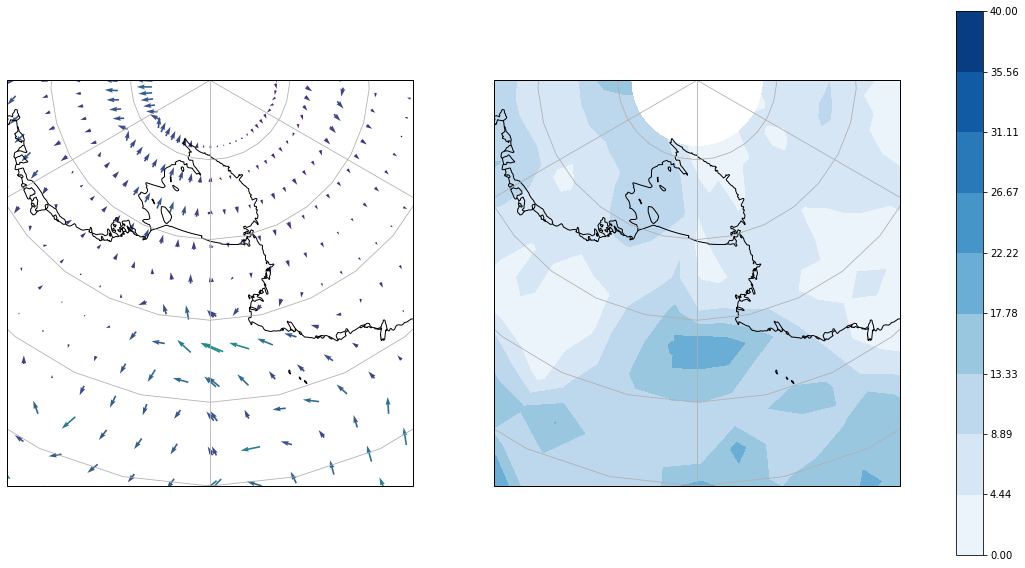

In [39]:
fig, ax=plt.subplots(ncols=2,nrows=1,figsize=(20,10),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})

# general map settings for all axes
for i in range(2):
    ax[i].set_extent([-210, -150, -90, -60], ccrs.PlateCarree()) #lon start, lon end, lat start, lat end
    grid=ax[i].gridlines()
    grid.n_steps=30
    
    #Add map
    ax[i].add_feature(ice_shelf_line)
    ax[i].coastlines(resolution='50m')


ax[0].quiver(lons.values, lats.values, u_wind.values, v_wind.values, # X, Y, U, V
             np.sqrt(u_wind**2+v_wind**2), cmap = 'viridis', # Values for coloring the vectors, colormap
             scale = 400, pivot='middle', width = .004, # settings to get them the size/look
             transform=ccrs.PlateCarree())

data, lon_adjust= add_cyclic_point(np.sqrt(u_wind**2+v_wind**2), coord=lons) # In order to avoid the wierd break in data at 180 lon
cf = ax[1].contourf(lon_adjust, lats, data , 
                    cmap = 'Blues', levels = np.linspace(0,40,10), 
                    transform=ccrs.PlateCarree())

cb = plt.colorbar(cf, ax =ax.ravel().tolist(),orientation='vertical')

# plt.savefig('example_pic.jpeg', dpi = 300,facecolor = 'white', transparent=True, bbox_inches = 'tight') 

